In [ ]:
# both files have some stores that are not in both 

# there is !REF error in dates, is that expected. 

In [201]:
# predict which plans would be better, and provide supporting evidence for your answer. 
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV


In [202]:
data = pd.read_excel("BevZTestHistory_clean.xls")
data.shape

(1381, 10)

In [203]:
data.describe()

,Week,Units_Sold,Average Retail Price,Sales_Rep,Endcap,Demo,Revenue
count,1381.000000,1381.00000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000
mean,6.002896,257.05441,4.107429,0.548154,0.038378,0.058653,1054.770978
std,3.165025,242.86067,0.464549,0.497856,0.192177,0.235059,1051.140583
min,1.000000,1.88000,2.890000,0.000000,0.000000,0.000000,9.210000
25%,3.000000,188.00000,3.780000,0.000000,0.000000,0.000000,754.290000
50%,6.000000,236.00000,4.100000,1.000000,0.000000,0.000000,961.050000
75%,9.000000,295.00000,4.430000,1.000000,0.000000,0.000000,1214.850000
max,11.000000,8100.00000,6.250000,1.000000,1.000000,1.000000,35559.000000


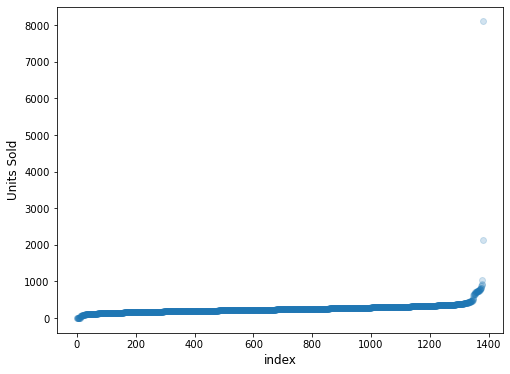

In [204]:
#check values again
plt.figure(figsize=(8,6))
plt.scatter(range(data.shape[0]), np.sort(data["Units_Sold"].values), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

In [205]:
print(data["Units_Sold"].quantile([.0, 0.01, 0.25, .5, 0.75, 0.99, 1]))
data = data[(data['Units_Sold'] <= 1552.20) & (data['Units_Sold']>=38.80) ]
print(data.shape)

0.00       1.88
0.01      56.80
0.25     188.00
0.50     236.00
0.75     295.00
0.99     752.20
1.00    8100.00
Name: Units_Sold, dtype: float64
(1368, 10)


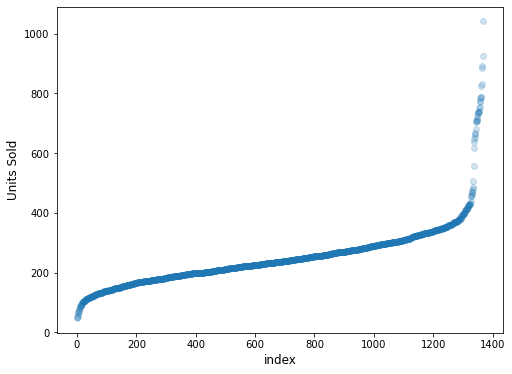

In [206]:
#check values again
plt.figure(figsize=(8,6))
plt.scatter(range(data.shape[0]), np.sort(data["Units_Sold"].values), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

In [207]:
data.describe()

,Week,Units_Sold,Average Retail Price,Sales_Rep,Endcap,Demo,Revenue
count,1368.00000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000
mean,6.00731,251.972222,4.103911,0.544591,0.035088,0.058480,1032.412376
std,3.16435,106.833896,0.464503,0.498190,0.184069,0.234734,441.477831
min,1.00000,48.000000,2.890000,0.000000,0.000000,0.000000,205.920000
25%,3.00000,190.000000,3.770000,0.000000,0.000000,0.000000,758.212500
50%,6.00000,236.000000,4.100000,1.000000,0.000000,0.000000,962.640000
75%,9.00000,295.000000,4.410000,1.000000,0.000000,0.000000,1215.770000
max,11.00000,1041.000000,6.250000,1.000000,1.000000,1.000000,4247.280000


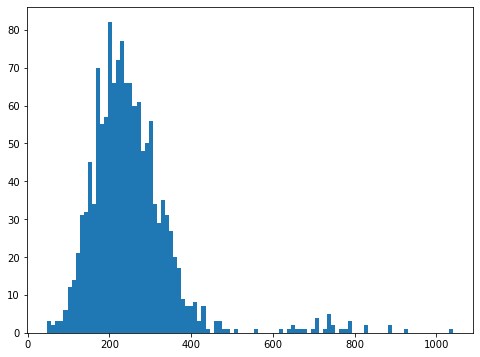

In [208]:
#check distribution using histogram
plt.figure(figsize=(8,6))
plt.hist(data["Units_Sold"].values, bins=100)
plt.show()

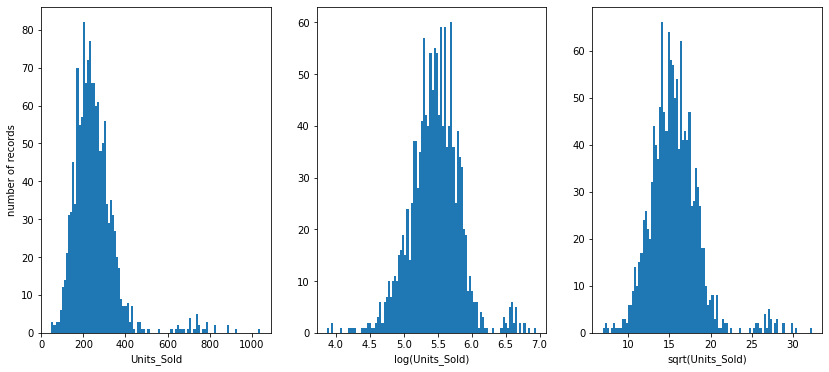

In [209]:
data['log_Units_Sold'] = np.log(data["Units_Sold"].values) #log transformation
data['sqrt_Units_Sold'] = np.sqrt(data["Units_Sold"].values) #square-root transformation

fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False)
fig.set_size_inches(14, 6)
ax[0].hist(data['Units_Sold'].values, bins=100)
ax[1].hist(data['log_Units_Sold'].values, bins=100)
ax[2].hist(data['sqrt_Units_Sold'].values, bins=100)
ax[0].set_ylabel('number of records')
ax[0].set_xlabel('Units_Sold')
ax[1].set_xlabel('log(Units_Sold)')
ax[2].set_xlabel('sqrt(Units_Sold)')
plt.show()

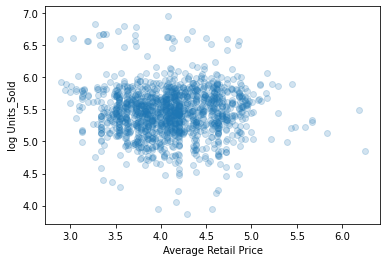

array([[ 1.        , -0.03345847],
       [-0.03345847,  1.        ]])

In [210]:
#explore units sold v.s. price: correlation?

plt.scatter(data["Average Retail Price"],data["log_Units_Sold"], alpha=0.2)
plt.xlabel('Average Retail Price')
plt.ylabel('log Units_Sold')
plt.show()
np.corrcoef(data["Average Retail Price"],data["Units_Sold"])

<AxesSubplot:title={'center':'log_Units_Sold'}, xlabel='[Week]'>

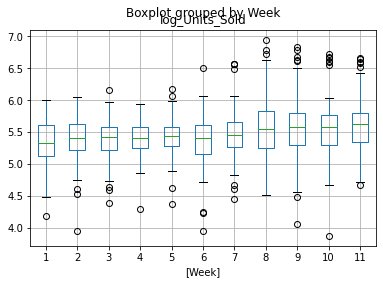

In [211]:
# Explore: Units_Sold v.s. week: correlation?
metric = 'Week'
y = 'log_Units_Sold'
data.boxplot(column=y, by=[metric])

In [212]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(pd.DataFrame(data["Region"]))
len(enc.categories_[0])
regionencoded = pd.DataFrame(enc.transform(pd.DataFrame(data["Region"])).toarray(), columns = ["Region"+str(i) for i in range(0,len(enc.categories_[0]))])

data["Sales_Rep"] = data["Sales_Rep"].astype("category")
data["Endcap"] = data["Endcap"].astype("category")
data["Demo"] = data["Demo"].astype("category")
data 

data.reset_index(drop=True, inplace=True)
regionencoded.reset_index(drop=True, inplace=True)


data_merge = data.join(regionencoded)

data_merge

,Date,Week,Store_Name,Region,Units_Sold,Average Retail Price,Sales_Rep,Endcap,Demo,Revenue,...,Region1,Region2,Region3,Region4,Region5,Region6,Region7,Region8,Region9,Region10
0,2020-10-08 00:00:00,1,Academy,Rocky Mountains,271.0,4.29,1,0,0,1162.59,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,8/17/20,2,Academy,Rocky Mountains,315.0,4.29,1,0,1,1351.35,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,8/24/20,3,Academy,Rocky Mountains,391.0,4.09,1,0,0,1599.19,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,8/31/20,4,Academy,Rocky Mountains,250.0,4.09,1,0,0,1022.50,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2020-07-09 00:00:00,5,Academy,Rocky Mountains,222.0,4.79,1,0,0,1063.38,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,9/21/20,7,Woodland Hills,South Pacific,333.0,4.77,1,0,0,1588.41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1364,9/28/20,8,Woodland Hills,South Pacific,232.0,4.99,1,0,0,1157.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1365,2020-05-10 00:00:00,9,Woodland Hills,South Pacific,316.0,5.16,1,0,1,1630.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1366,2020-12-10 00:00:00,10,Woodland Hills,South Pacific,262.0,4.95,1,0,0,1296.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [196]:

data_merge.to_excel("BevZTestHistory_clean_updated.xls", index=False, engine="xlwt")

/var/folders/f8/x7313zpd31v5yyfbr5c8sf840000gn/T/ipykernel_21621/2445602657.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  data_merge.to_excel("BevZTestHistory_clean_updated.xls", index=False, engine="xlwt")


In [218]:
#pick the features that makes sense: no target variables, or variables have to be calcuated directly from target
#aka no variables that don't exist in the validation or test set.


ind = list(list(range(1,2))+ list(range(5,9))+ list(range(12,23)))
features = data_merge.columns[ind]

features


Index(['Week', 'Average Retail Price', 'Sales_Rep', 'Endcap', 'Demo',
       'Region0', 'Region1', 'Region2', 'Region3', 'Region4', 'Region5',
       'Region6', 'Region7', 'Region8', 'Region9', 'Region10'],
      dtype='object')

In [219]:
# split train and validation by 80% and 20%
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train_set = data_merge[msk].copy()
val_set = data_merge[~msk].copy()
print(train_set.shape, val_set.shape)

(1108, 23) (260, 23)


In [222]:
train_X = train_set[features]
train_X['intercept'] = 1

val_X = val_set[features]
val_X['intercept'] = 1

# test_X=test[features]

train_y = train_set['log_Units_Sold'].values
val_y = val_set['log_Units_Sold'].values

/var/folders/f8/x7313zpd31v5yyfbr5c8sf840000gn/T/ipykernel_21621/1399446714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X['intercept'] = 1
/var/folders/f8/x7313zpd31v5yyfbr5c8sf840000gn/T/ipykernel_21621/1399446714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X['intercept'] = 1


In [223]:
####statsmodels
import statsmodels.api as sm
lm_1 = sm.OLS(train_y, train_X)
results = lm_1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     66.91
Date:                Wed, 28 Jun 2023   Prob (F-statistic):          7.87e-143
Time:                        16:47:45   Log-Likelihood:                -109.54
No. Observations:                1108   AIC:                             251.1
Df Residuals:                    1092   BIC:                             331.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Week                     0.0129 

In [224]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression

lm_2 = LinearRegression()
lm_2.fit(train_X, train_y)
lm_2.score(val_X, val_y) #R^2

0.48879876478924855

In [225]:
val_pred = lm_2.predict(val_X)
rmse = sqrt(mean_squared_error(val_y, val_pred))
print(rmse)

0.2737043292739433


In [227]:
# removing sales rep

ind = list(list(range(1,2))+ list(range(5,6))+ list(range(7,9)) + list(range(12,23)))
features = data_merge.columns[ind]
features

# split train and validation by 80% and 20%
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train_set = data_merge[msk].copy()
val_set = data_merge[~msk].copy()
print(train_set.shape, val_set.shape)

train_X=train_set[features]
val_X=val_set[features]
# test_X=test[features]

train_y = train_set['log_Units_Sold'].values
val_y = val_set['log_Units_Sold'].values

####statsmodels
import statsmodels.api as sm
lm_1 = sm.OLS(train_y, train_X)
results = lm_1.fit()
print(results.summary())

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
lm_2 = LinearRegression()
lm_2.fit(train_X, train_y)
print(lm_2.score(val_X, val_y)) #R^2

val_pred = lm_2.predict(val_X)
rmse = sqrt(mean_squared_error(val_y, val_pred))
print(rmse)


(1108, 23) (260, 23)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     71.66
Date:                Wed, 28 Jun 2023   Prob (F-statistic):          1.28e-143
Time:                        16:49:21   Log-Likelihood:                -109.90
No. Observations:                1108   AIC:                             249.8
Df Residuals:                    1093   BIC:                             324.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Week       

In [157]:
data = pd.read_csv("BevZNextPhaseRolloutPlans.csv")
data = data.iloc[:, :-3]
data

,,store_name,address,city,state,Region,Date,Average Retail Price,Sales Rep,Endcap,Demo
0,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,1/10/22,$3.50,1,0,0
1,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,1/17/22,$3.50,1,1,0
2,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,1/24/22,$3.50,1,1,1
3,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,1/31/22,$3.50,1,1,0
4,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,2/7/22,$3.50,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4003,Tony,Whole Foods Market,9940 NE Cornell Rd,Hillsboro,OR,South Pacific,2/22/21,$ 3.50,0,1,0
4004,Tony,Whole Foods Market,9940 NE Cornell Rd,Hillsboro,OR,South Pacific,3/1/21,$ 3.50,0,1,1
4005,Tony,Whole Foods Market,9940 NE Cornell Rd,Hillsboro,OR,South Pacific,3/8/21,$ 3.00,0,0,0
4006,Tony,Whole Foods Market,9940 NE Cornell Rd,Hillsboro,OR,South Pacific,3/15/21,$ 3.50,0,1,0


In [73]:
data["Region"].unique()

array(['Southwest', 'Northeast', 'Rocky Mountains', 'Midwest',
       'Mid Atlantic', 'South', 'North Atlantic', 'Pacific Northwest',
       'Northern California', 'South Pacific', 'Florida'], dtype=object)

In [23]:
data["Retail_Price"] = data.iloc[:,-4].str.replace("$", "")
data = data.drop(columns=data.columns[7])

/var/folders/f8/x7313zpd31v5yyfbr5c8sf840000gn/T/ipykernel_7730/4271677600.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data["Retail_Price"] = data.iloc[:,-4].str.replace("$", "")


In [43]:
data["Sales Rep"] = data["Sales Rep"].astype("category")
data["Endcap"] = data["Endcap"].astype("category")
data["Demo"] = data["Demo"].astype("category")
data

,,store_name,address,city,state,Region,Date,Sales Rep,Endcap,Demo,Retail_Price
0,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,1/10/22,1,0,0,3.50
1,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,1/17/22,1,1,0,3.50
2,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,1/24/22,1,1,1,3.50
3,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,1/31/22,1,1,0,3.50
4,Sandy,Whole Foods Market,"5100 Belt Line Rd, Ste 1012",Addison,TX,Southwest,2/7/22,1,1,1,3.50
...,...,...,...,...,...,...,...,...,...,...,...
4003,Tony,Whole Foods Market,9940 NE Cornell Rd,Hillsboro,OR,South Pacific,2/22/21,0,1,0,3.50
4004,Tony,Whole Foods Market,9940 NE Cornell Rd,Hillsboro,OR,South Pacific,3/1/21,0,1,1,3.50
4005,Tony,Whole Foods Market,9940 NE Cornell Rd,Hillsboro,OR,South Pacific,3/8/21,0,0,0,3.00
4006,Tony,Whole Foods Market,9940 NE Cornell Rd,Hillsboro,OR,South Pacific,3/15/21,0,1,0,3.50


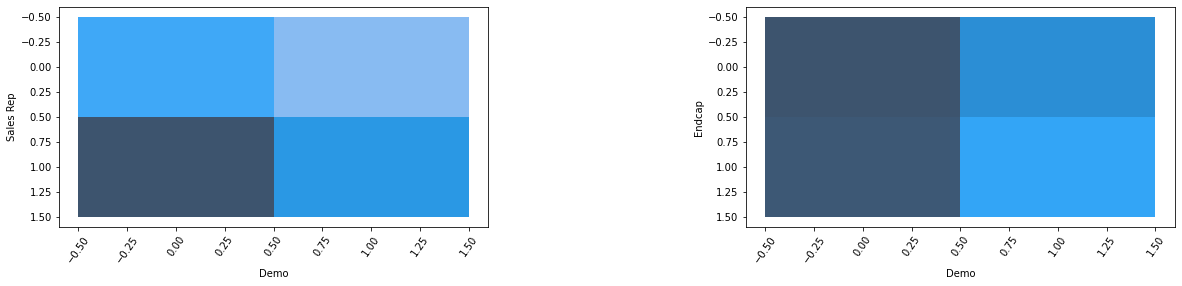

In [45]:
plt.figure(1 , figsize = (20 , 17))
n=0
for y in ['Sales Rep' , 'Endcap']:
    n += 1
    plt.subplot(3, 2 , n)
    plt.subplots_adjust(hspace = 0.6 , wspace = 0.6)
    chart = sns.histplot(x = 'Demo' , y = y , data = data)
    plt.ylabel(y) #ternary condition
    plt.xticks(rotation=55)
plt.show()


In [32]:

data["Date"] = pd.to_datetime(data["Date"])
#data["Date"].min()

ParserError: Unknown string format: #REF!

In [85]:
import datetime

def change_date_column(data):
    """
    Change the date column to a list of integers.

    Args:
        data (list): The data to be changed.

    Returns:
        list: The changed data.
    """

    new_data = []
    for date in data:
        new_date = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        week_number = new_date.isocalendar()[1]
        new_data.append(week_number)
    return new_data


if __name__ == "__main__":
    data = ["2023-02-01", "2023-02-08", "2024-04-23"]

    changed_data = change_date_column(data)

    print(changed_data)


[5, 6, 17]


In [ ]:
import datetime

def calculate_weeks_difference(start_date, end_date):
    """
    Calculate the difference in dates in terms of weeks.

    Args:
        start_date (str): The start date.
        end_date (str): The end date.

    Returns:
        int: The difference in weeks.
    """

    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    f["A"] -= df.loc[0, "A"]
    difference_in_days = (end_date - df.loc[0, ""]).days // 7
    weeks_difference = difference_in_days // 7

    return weeks_difference


In [87]:
for x in df["Region"].unique():
    print(x)

Southwest
Northeast
Rocky Mountains
Midwest
Mid Atlantic
South
North Atlantic
Pacific Northwest
Northern California
South Pacific
Florida


In [ ]:
import pandas as pd
import datetime

def calculate_weeks_difference(start_date, end_date):
    """
    Calculate the difference in dates in terms of weeks.

    Args:
        start_date (str): The start date.
        end_date (str): The end date.

    Returns:
        int: The difference in weeks.
    """

    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()

    difference_in_days = (end_date - start_date).days
    weeks_difference = difference_in_days // 7

    return weeks_difference


def arrange_dataframe(df, region):
    """
    Arrenge the dataframe in ascending order of dates for a specific region.

    Args:
        df (pd.DataFrame): The dataframe to be arranged.
        region (str): The region to be arranged.

    Returns:
        pd.DataFrame: The arranged dataframe.
    """
    for df[df["Region"]] in df["Region"].unique()
    df = df[df["Region"] == region]
    df = df.sort_values(by="Date", ascending=True)
    return df


def add_weeks_difference_column(df):
    """
    Add a column to the dataframe with the difference in weeks between the date in row 0 and all other rows.

    Args:
        df (pd.DataFrame): The dataframe to be arranged.

    Returns:
        pd.DataFrame: The dataframe with the new column.
    """

    df["Weeks Difference"] = df["Date"].apply(lambda x: calculate_weeks_difference(df.loc[0, "Date"], x))

    return df


if __name__ == "__main__":
    df = pd.DataFrame({
        "Region": ["North", "South", "East", "West"],
        "Date": ["2023-01-01", "2023-03-08", "2023-02-14", "2023-04-22"],
    })

    df = arrange_dataframe(df, "North")
    df = add_weeks_difference_column(df)

    print(df)

In [74]:
data = pd.read_csv("BevZTestHistory.csv")
data

,Date,Store_Name,Region,Units_Sold,Average Retail Price,Sales_Rep,Endcap,Demo
0,8/10/20,Academy,Rocky Mountains,271.0,$4.29,1,0,0
1,8/17/20,Academy,Rocky Mountains,315.0,$4.29,1,0,1
2,8/24/20,Academy,Rocky Mountains,391.0,$4.09,1,0,0
3,8/31/20,Academy,Rocky Mountains,250.0,$4.09,1,0,0
4,9/7/20,Academy,Rocky Mountains,222.0,$4.79,1,0,0
...,...,...,...,...,...,...,...,...
1381,9/21/20,Woodland Hills,South Pacific,333.0,$4.77,1,0,0
1382,9/28/20,Woodland Hills,South Pacific,232.0,$4.99,1,0,0
1383,10/5/20,Woodland Hills,South Pacific,316.0,$5.16,1,0,1
1384,10/12/20,Woodland Hills,South Pacific,262.0,$4.95,1,0,0


In [75]:
data["Region"].unique()

array(['Rocky Mountains', 'Southwest', 'South', 'Midwest', 'Mid Atlantic',
       'South Pacific', 'North Atlantic', 'Pacific Northwest', 'Florida',
       'Northeast', 'Northern California'], dtype=object)

In [76]:
data["Average Retail Price"] = data.iloc[:,-4].str.replace("$", "")
data["Sales_Rep"] = data["Sales_Rep"].astype("category")
data["Endcap"] = data["Endcap"].astype("category")
data["Demo"] = data["Demo"].astype("category")


# encoding categorical variables to be numeric
encoder = OneHotEncoder()
encodedworkclass = encoder.fit_transform(data[["Store_Name"]])
encodedStore_Name_df = pd.DataFrame(encodedworkclass.toarray(), columns = ["Store"+str(i) for i in range(0,len(encodedworkclass.toarray()[0]))])




/var/folders/f8/x7313zpd31v5yyfbr5c8sf840000gn/T/ipykernel_7730/1141804609.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data["Average Retail Price"] = data.iloc[:,-4].str.replace("$", "")


In [81]:
data["Date"] = pd.to_datetime(data["Date"])
data["Date"].min()

Timestamp('2020-08-10 00:00:00')

In [54]:
data["Store_Name"].unique()

array(['Academy', 'Alamo Quarry', "Alpharetta (aka Alpharetta Harry's)",
       'Ann Arbor', 'Annapolis', 'Arroyo', 'Bedford', 'Bellaire',
       'Bellevue', 'Bellingham', 'Belmar', 'Bend', 'Bethesda',
       'Biscayne (aka Aventura)', 'Boca Raton', 'Bowery', 'Bridgeport',
       'Cedar Center', 'Cerrillos (aka Santa Fe)', 'Chelsea',
       "Cobb (aka Cobb Harry's)", 'Columbus', 'Columbus Circle',
       'Coral Gables', 'Coral Springs',
       'Cranston (aka Garden City Center)', 'Deerfield', 'Duluth',
       'Edgewater', 'Fair Lakes', 'Fairfax', 'Forest', 'Fort Apache',
       'Fort Collins', 'Fort Lauderdale', 'Framingham', 'Fremont',
       'Fresh Pond', 'Fresno', 'Galleria', 'Georgetown', 'Glendale',
       'Gold Coast', 'Green Hills', 'Hadley', 'Henderson',
       'Highlands Ranch', 'Hingham', 'Jamboree', 'Jenkintown', 'Jericho',
       'Kentlands', 'Lake Calhoun (aka Minneapolis)', 'Lakeview', 'Lamar',
       'Las Vegas Blvd', 'Los Altos', 'Louisville', 'Marlton', 'Metcalf',
    

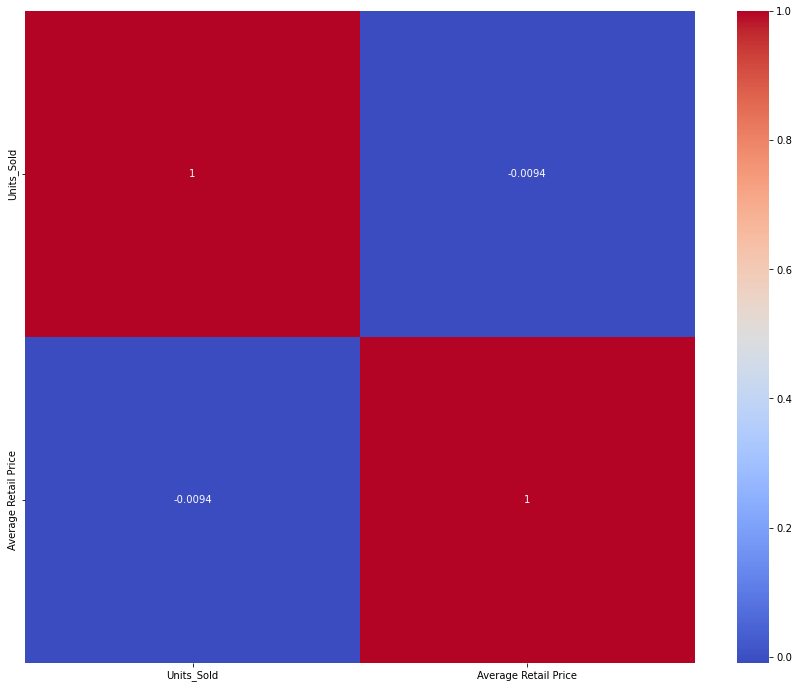

In [62]:
correlations = data.corr(method='pearson')
plt.figure(figsize=(15, 12))
sns.heatmap(correlations, cmap="coolwarm", annot=True)
plt.show()